# Passos (resumo)

* EDA geral
* Preparação dos dados pra regressão linear e xgboost (apenas com target e total de transações). Aplicar as lags, etc
* Preparação dos dados pro ARIMA
* Comparação de performances
* Verificar se é válido incluir mais features (agrupadas+lags)

# Bibliotecas

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Data viz
import matplotlib.pyplot as plt
import seaborn as sns

# statistics / ML
# from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
# Cor dos gráficos
c1 = '#8B4513'
c2 = "YlOrBr_r"
c3 = "YlOrBr"

# 1. Obtenção dos dados

In [4]:
import os
if not os.path.exists('data'):
    os.makedirs('data')

In [5]:
# !kaggle datasets download -d ahmedabbas757/coffee-sales -p data --unzip

# 2. Importação dos dados

In [6]:
data = pd.read_excel('data/Coffee Shop Sales.xlsx')

In [7]:
print(f'Linhas: {data.shape[0]}')
print(f'Colunas: {data.shape[1]}')

Linhas: 149116
Colunas: 11


In [8]:
data.head(3)

,transaction_id,transaction_date,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail
0,1,2023-01-01,07:06:11,2,5,Lower Manhattan,32,3.0,Coffee,Gourmet brewed coffee,Ethiopia Rg
1,2,2023-01-01,07:08:56,2,5,Lower Manhattan,57,3.1,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg
2,3,2023-01-01,07:14:04,2,5,Lower Manhattan,59,4.5,Drinking Chocolate,Hot chocolate,Dark chocolate Lg


# 3. Inspeção geral dos dados

| **Variável**            | **Descrição**                                                                                   |
|------------------------|-----------------------------------------------------------------------------------------------|
| **transaction_id**     | ID sequencial único representando uma transação individual                                    |
| **transaction_date**   | Data da transação (MM/DD/YY)                                                                  |
| **transaction_time**   | Horário da transação (HH:MM:SS)                                                               |
| **transaction_qty**    | Quantidade de itens vendidos                                                                  |
| **store_id**           | ID único da cafeteria onde a transação ocorreu                                               |
| **store_location**     | Localização da cafeteria onde a transação ocorreu                                            |
| **product_id**         | ID único do produto vendido                                                                  |
| **unit_price**         | Preço de varejo do produto vendido                                                           |
| **product_category**   | Descrição da categoria do produto                                                            |
| **product_type**       | Descrição do tipo de produto                                                                 |
| **product_detail**     | Descrição do detalhe do produto                                                              |


# 4.Split dos dados

`Observação`: Como o projeto envolve séries temporais, é essencial que os conjuntos de treino e teste sejam divididos com base no tempo, preservando a ordem cronológica dos dados. Seleções aleatórias podem causar vazamento de informações, uma vez que dados futuros poderiam influenciar a previsão de eventos passados.

In [9]:
# Exploração do ponto de corte (data)
data['transaction_date'] = pd.to_datetime(data['transaction_date'])
data['transaction_date'].dt.to_period('M').unique()

<PeriodArray>
['2023-01', '2023-02', '2023-03', '2023-04', '2023-05', '2023-06']
Length: 6, dtype: period[M]

* Os dados disponíveis correspondem a 6 meses de vendas da cafeteria
* O objetivo é usar os dados dos primeiros 5 meses (janeiro, fevereiro, março, abril e maio) para prever o último mês (junho)
* O agrupamento será feito por dia, ou seja, 150 dias para treino (5 meses) e 30 dias para o teste (1 mês)

In [10]:
# Ponto de corte
train_end_date = '2023-05-31'

In [11]:
# Criando os conjuntos de treino e teste
train = data[data['transaction_date'] <= train_end_date]
test = data[data['transaction_date'] > train_end_date]

print(f'Linhas do treino {train.shape[0]}')
print(f'Linhas do teste {test.shape[0]}')

Linhas do treino 113764
Linhas do teste 35352


### 4.1 Agrupamento temporal

In [12]:
# Agrupado por dia

# Treino

# df_train_grouped = train.groupby('transaction_date').agg({'unit_price':'sum', 'transaction_id':'count'}).reset_index()
df_train_grouped = train.groupby('transaction_date').agg({'unit_price':'sum'}).reset_index()

# Teste

# df_test_grouped = test.groupby('transaction_date').agg({'unit_price':'sum', 'transaction_id':'count'}).reset_index()
df_test_grouped = test.groupby('transaction_date').agg({'unit_price':'sum'}).reset_index()

In [13]:
# Treino

df_train_grouped.shape

(151, 2)

In [14]:
# Teste

df_test_grouped.shape

(30, 2)

In [15]:
# Demonstração

display(df_train_grouped.head())
display(df_test_grouped.head())

,transaction_date,unit_price
0,2023-01-01,1731.80
1,2023-01-02,1743.95
2,2023-01-03,1826.60
3,2023-01-04,1533.40
4,2023-01-05,1715.35


,transaction_date,unit_price
0,2023-06-01,3612.30
1,2023-06-02,3537.65
2,2023-06-03,3659.45
3,2023-06-04,3453.45
4,2023-06-05,3484.25


# 5. EDA (geral)

In [16]:
train = train.copy()

Foi realizada uma EDA geral para fins de conhecimento da base de dados e para verificar possíveis insights na possível construção de features para o modelo.

### 5.1 Quantidade de transações por localidade

A localidade com mais vendas foi a de Lower Manhattan (33,50%), Hell's Kitchen (33,40%) e Astoria (33,11%).

In [17]:
location_sales = train.groupby('store_location', as_index=False).agg(sum_transaction_qty=('transaction_qty','sum'))

location_sales['percentage'] = np.round((location_sales['sum_transaction_qty'] / location_sales['sum_transaction_qty'].sum()) * 100,2)

location_sales.sort_values(by='percentage', ascending=False,inplace=True)

location_sales

,store_location,sum_transaction_qty,percentage
2,Lower Manhattan,54777,33.50
1,Hell's Kitchen,54613,33.40
0,Astoria,54138,33.11


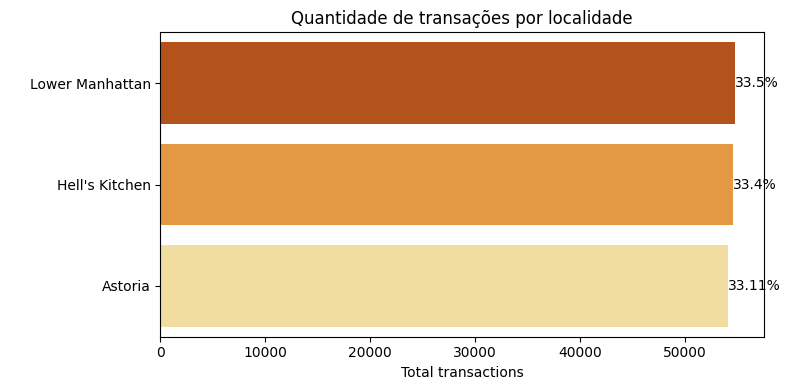

In [18]:
ordered_locations = location_sales.sort_values(by='sum_transaction_qty', ascending=False)['store_location']

# Gráfico
plt.figure(figsize=(8, 4))
sns.barplot(
    x='sum_transaction_qty',
    y='store_location',
    data=location_sales,
    palette=c2,
    order=ordered_locations  # Forçando a ordem correta
)

# Porcentagens
for index, row in location_sales.iterrows():
    plt.text(
        row['sum_transaction_qty'] + 0.5,
        row['store_location'],
        f"{row['percentage']}%", 
        va='center',
        fontsize=10
    )

plt.title('Quantidade de transações por localidade', fontsize=12)
plt.xlabel('Total transactions', fontsize=10)
plt.ylabel(' ')
plt.tight_layout()
plt.show()

### 5.2 Total de faturamento por localidade ao longo do meses

As localidades tiveram o faturamento semelhante ao longo dos meses, assim como suas distribuições na base de dados.

In [19]:
df_stores = train.groupby(['store_location','transaction_date']).agg(sum_unit_price=('unit_price', 'sum'), 
                                                                     count_transaction_id=('transaction_id', 'count')).reset_index()

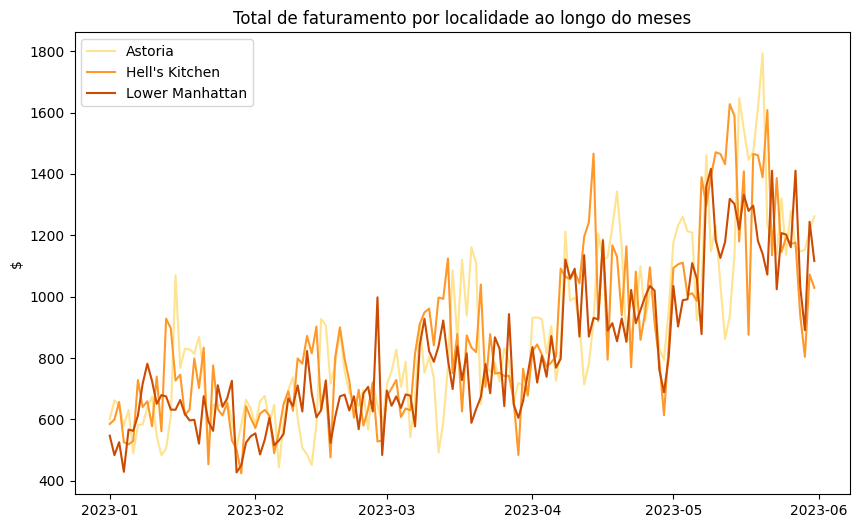

In [20]:
# Paleta de cores
palette = sns.color_palette(c3, len(df_stores['store_location'].unique()))

# Gráfico
plt.figure(figsize=(10, 6))
for idx, store in enumerate(df_stores['store_location'].unique()):
    plt.plot(
        df_stores.loc[df_stores['store_location'] == store, 'transaction_date'], 
        df_stores.loc[df_stores['store_location'] == store, 'sum_unit_price'], 
        label=store, 
        color=palette[idx],
    )

plt.title('Total de faturamento por localidade ao longo do meses', fontsize=12)
plt.ylabel('$')
plt.legend()
plt.show()

### 5.3 Faturamento total por mês

O mes de maio foi o de maior faturamento total.

In [21]:
# Criando uma nova coluna com o mês e o ano isolados
train.loc[:, 'transaction_month'] = train['transaction_date'].dt.to_period('M')

# Agrupando o faturamento por mês
transaction_month_price = train.groupby('transaction_month',as_index=False).agg(sum_unit_price=('unit_price','sum'))
transaction_month_price.sort_values(by='sum_unit_price',ascending=False)

,transaction_month,sum_unit_price
4,2023-05,113076.91
3,2023-04,85709.58
2,2023-03,71833.08
0,2023-01,59018.04
1,2023-02,55134.34


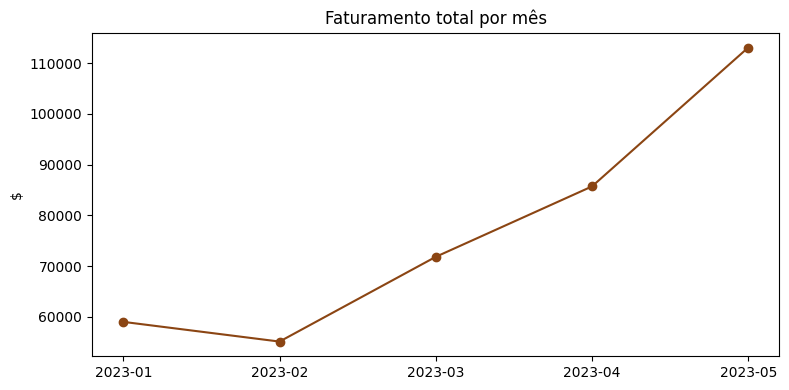

In [22]:
# Convertendo a coluna 'transaction_month' para string para o gráfico
transaction_month_price['transaction_month'] = transaction_month_price['transaction_month'].astype(str)

# Gráfico
plt.figure(figsize=(8, 4))
plt.plot(
    transaction_month_price['transaction_month'], 
    transaction_month_price['sum_unit_price'], 
    color=c1,
    marker='o'
)

plt.title('Faturamento total por mês', fontsize=12)
plt.ylabel('$')
plt.tight_layout()
plt.show()

### 5.4 Faturamrento total por categoria do produto

Os produtos que mais costumam vender são: Coffee, Tea e Bakery.

In [23]:
# Agrupando o faturamento por categoria de produto

faturamento_por_categoria = train.groupby('product_category',as_index=False).agg(sum_unit_price=('unit_price','sum'))
faturamento_por_categoria.sort_values(by='sum_unit_price',ascending=False,inplace=True)

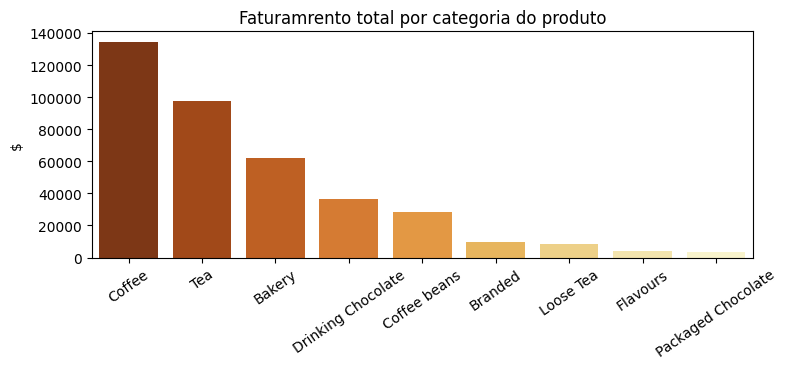

In [24]:
# Gráfico

plt.figure(figsize=(8, 4))
sns.barplot(x='product_category', y='sum_unit_price', data=faturamento_por_categoria, palette=c2)
plt.title('Faturamrento total por categoria do produto', fontsize=12)
plt.xticks(rotation=35)
plt.tight_layout()
plt.xlabel(' ')
plt.ylabel('$')
plt.show()

In [25]:
faturamento_por_categoria

,product_category,sum_unit_price
2,Coffee,134321.25
8,Tea,97850.65
0,Bakery,62024.22
4,Drinking Chocolate,36394.00
3,Coffee beans,28228.60
1,Branded,9966.00
6,Loose Tea,8442.95
5,Flavours,4128.80
7,Packaged Chocolate,3415.48


### 5.5 Faturamento total por horário do dia

10, 9 e 8h da manhã costumam ser os horários com maior faturamento total.

In [26]:
# Extraindo a parte inteira da coluna de hora
train['hour'] = train['transaction_time'].apply(lambda x: x.hour)

# Agrupando por hora e somando o `unit_price`
total_ganho_por_horario = train.groupby('hour')['unit_price'].sum().reset_index()
total_ganho_por_horario.columns = ['hour', 'sum_unit_price']
total_ganho_por_horario.sort_values(by='sum_unit_price', ascending=False,inplace=True)
total_ganho_por_horario

,hour,sum_unit_price
4,10,49504.77
3,9,47011.45
2,8,46800.60
1,7,35284.74
5,11,24686.07
10,16,23061.84
9,15,22834.92
8,14,22420.99
7,13,22140.31
11,17,21863.12


Após as 10h, há uma redução significativa, que mantem-se estável até cair completamente (20h). A diminuição do horário das 20h faz sentido, considerando que é o último horário da cafeteria.

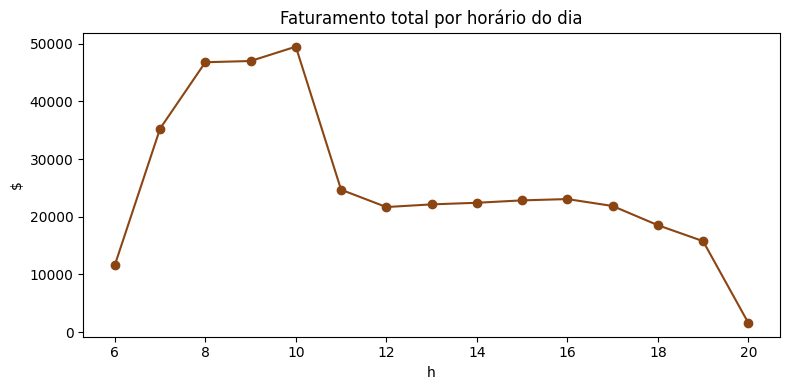

In [27]:
total_ganho_por_horario.sort_values(by='hour', ascending=False,inplace=True)

# Gráfico
plt.figure(figsize=(8, 4))
plt.plot(
    total_ganho_por_horario['hour'], 
    total_ganho_por_horario['sum_unit_price'], 
    color=c1,
    marker='o'
)

plt.title('Faturamento total por horário do dia', fontsize=12)
plt.xlabel('h')
plt.ylabel('$')
plt.tight_layout()
plt.show()

### 5.6 Faturamento total por dia da semana

* Quarta-feira (Wednesday) parece ser o dia da semana com maior faturamento total
* Sexta-feira (Friday) parece ser o dia da semana com menor faturamento total.

In [28]:
# Criar uma coluna com o dia da semana
train['day_of_week'] = train['transaction_date'].dt.day_name()

# Agrupar pelo dia da semana e somar os ganhos
total_ganho_por_dia = train.groupby('day_of_week')['unit_price'].sum().reset_index()

# Ordenar os dias da semana na sequência correta
dias_da_semana = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
total_ganho_por_dia['day_of_week'] = pd.Categorical(total_ganho_por_dia['day_of_week'], categories=dias_da_semana, ordered=True)
total_ganho_por_dia = total_ganho_por_dia.sort_values('day_of_week')
total_ganho_por_dia.columns = ['day_of_Week', 'sum_unit_price']

# Exibir o resultado
total_ganho_por_dia

,day_of_Week,sum_unit_price
1,Monday,56586.57
5,Tuesday,56114.22
6,Wednesday,56680.99
4,Thursday,53161.10
0,Friday,53001.08
2,Saturday,53532.68
3,Sunday,55695.31


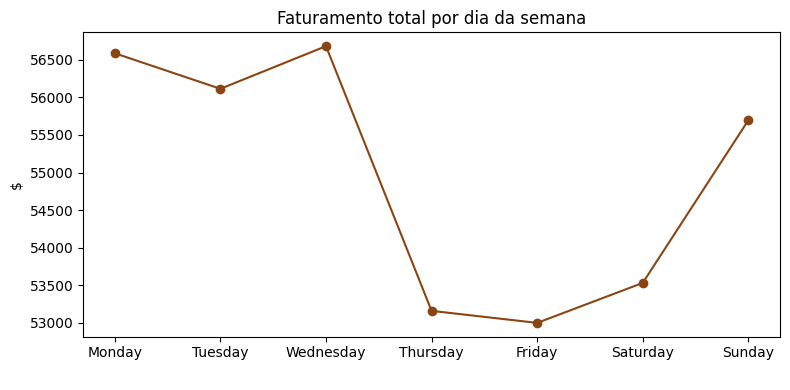

In [29]:
# Gráfico
plt.figure(figsize=(8, 4))
plt.plot(
    total_ganho_por_dia['day_of_Week'], 
    total_ganho_por_dia['sum_unit_price'], 
    color=c1,
    marker='o'
)

plt.title('Faturamento total por dia da semana', fontsize=12)
plt.xlabel(' ')
plt.ylabel('$')
plt.tight_layout()
plt.show()

# 6. Preparação dos dados

### 6.1 Definição das lags

* Os dados são divididos em lags para capturar a dependência temporal entre observações passadas e o valor atual ou futuro que queremos prever. Essa abordagem permite que os modelos aprendam padrões temporais e façam previsões baseadas em informações históricas;

* O método .shift() desloca os valores da coluna unit_price para "baixo" em x posições. Será utilizado para definir as lags;

* Neste projeto, foram definidas as lags de 7, 14 e 28 dias (uma semana, duas semanas e quatro semanas);

* As lags se tornarão as features, enquanto o `unit_price` será o target.

In [30]:
# Definindo diferentes lags (1 a 28)

for lag in range(1, 29):
    df_train_grouped[f'unit_price_lag{lag}'] = df_train_grouped['unit_price'].shift(lag)

In [33]:
df_train_grouped.head(5)

,transaction_date,unit_price,unit_price_lag1,unit_price_lag2,unit_price_lag3,unit_price_lag4,unit_price_lag5,unit_price_lag6,unit_price_lag7,unit_price_lag8,...,unit_price_lag19,unit_price_lag20,unit_price_lag21,unit_price_lag22,unit_price_lag23,unit_price_lag24,unit_price_lag25,unit_price_lag26,unit_price_lag27,unit_price_lag28
0,2023-01-01,1731.80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-01-02,1743.95,1731.80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-01-03,1826.60,1743.95,1731.80,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-01-04,1533.40,1826.60,1743.95,1731.80,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2023-01-05,1715.35,1533.40,1826.60,1743.95,1731.8,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
# O que é feito com os nans? Dropar? Preencher com a média ou mediana?
# Definir a melhor quantidade de lags pro treino
# Separar X_train (tudo menos unit_price) e X_test (apenas unit_price)
# Dá pra usar uma feature selection pra dizer quais lags serão mais importantes